In [1]:
from essi21 import mixing as mm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Table 1 from Costello et al. (2018)
df = mm.read_lambda_table()
df.head(10)

,n,10%,50%,99%
0,1.0,0.105,0.693,4.605
1,2.0,0.530,1.678,6.638
2,3.0,1.102,2.674,8.406
3,4.0,1.742,3.672,10.050
4,6.0,3.150,5.670,13.110
5,8.0,4.655,7.670,16.000
6,10.0,6.221,9.670,18.870
7,20.0,14.530,19.670,31.850
8,30.0,23.330,29.670,44.190
9,40.0,32.110,39.670,56.160


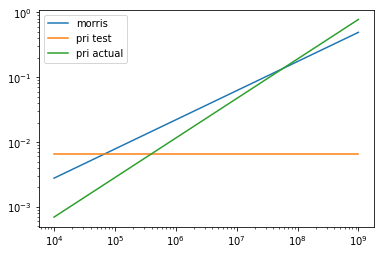

In [3]:
plt.figure(figsize=(6, 4))

time_arr = np.logspace(4, 9)
ot_morris = mm.overturn_depth_morris(time_arr)
ot_pri = mm.get_overturn_depths(time_arr, 1, regimes=['primary'])
ot_sec = mm.get_overturn_depths(time_arr, regimes=['secondary'])
# ot_mm = mm.get_overturn_depths(time_arr, regimes=['micrometeorite'])

ot_test = mm.get_overturn_depths(time_arr, 1, '50%')
ot_actual = 2.52e-6 * time_arr ** 0.61


plt.loglog(time_arr, ot_morris, label='morris')
plt.loglog(time_arr, ot_test, label='pri test')
plt.loglog(time_arr, ot_actual, label='pri actual')
# plt.loglog(time_arr, ot_pri, label='primary')
# plt.loglog(time_arr, ot_sec, label='secondary')
# plt.loglog(time_arr, ot_mm, label='micrometeorite')
# plt.ylim(1e1, 1e-3)
# plt.xlim(4, 9)
plt.legend()
plt.show()

6.3e-11 -2.7 0.693


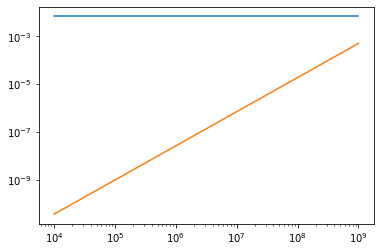

In [6]:
n = 1
prob = '50%'
u, v = mm.OVERTURN_UV['primary']
lam = mm.overturn_lambda(n, prob)
print(u, v, lam)
d = mm.overturn_depth(time_arr, lam, u, v)
plt.loglog(time_arr, ot_test, label='pri test')
plt.loglog(time_arr, d, label='pri actual')

In [5]:
# constants
c = 0.41
d = 1/3
g = 1.61e15

# primaries
a = 6.3e-11
b = -2.7
vf = 5.7e11
rhom = 2500
K1 = 0.132
K2 = 0.26
Kr = 1.1
Kd = 0.6
mu = 0.41
Y = 0.01
rhot = 1500
alpha = K2 * (( (Y/rhot)*vf**2 )**(0.5*(2+mu)))
beta = (-3*mu)/(2+mu)
gamma = (K1*np.pi*rhom)/(6*rhot)
di = 2 * Kr
eps = (g/(2*vf**2))*(rhom/rhot)**(1/3)

def overturn_grav(lam, t):
    t1 = d * Kd/(2*Kr)
    t2_num = 4 * lam * (di*(gamma*eps**beta)**(1/3))**((3*b)/(3+beta))
    t2_den = a * (c**2) * np.pi * t
    exp = (3 + beta) / (3 * b + 3 + beta)
    return t1 * (t2_num/t2_den)**exp

times = (1e2, 1e6, 1e9)
for t, og in enumerate(('og100', 'og1M', 'og1G')):
    for lam in ('L10', 'L50', 'L99'):
        df[og+lam] = 10*overturn_grav(df[lam], times[t])

def overturn_str(lam, t):
    t1 = d * Kd/(2*Kr)
    t2_num = 4 * lam * (di*(gamma*alpha**beta)**(1/3))**b
    t2_den = a * (c**2) * np.pi * t
    exp = 1 / (b + 1)
    return t1 * (t2_num/t2_den)**exp

times = (1e2, 1e6, 1e9)
for t, og in enumerate(('os100', 'os1M', 'os1G')):
    for lam in ('L10', 'L50', 'L99'):
        df[og+lam] = 10*overturn_str(df[lam], times[t])

def cum_turns(lam, Dc=1, t=1, c=1):
    return (4*lam)/(np.pi*(c**2)*Dc*t)

df['RD10'] = cum_turns(df['L10'], 1, 100, c=0.41)
df['RD50'] = cum_turns(df['L50'], 1, 100, c=0.41)
df['RD99'] = cum_turns(df['L99'], 1, 100, c=0.41)

def overturn(t, lam, dH, c=0.41, u=1, v=1):
    num = 4 * lam
    den = u*np.pi*(c**2)*t
    exp = 1/(v+1)
    return dH * (num/den)**exp


def ot50(t):
    d = 7.07e-7 * t**0.59
    large = d>0.6
    d[large] = 1.58e-5 * t[large]**0.44
    return d

df.head()

KeyError: 'L10'

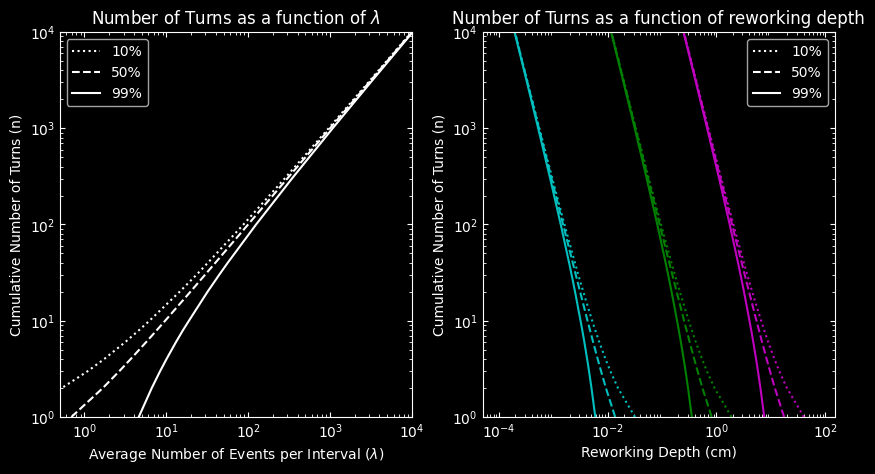

In [12]:
plt.style.use('default')
plt.style.use('dark_background')
plt.rcParams.update({
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',

})
f, axs = plt.subplots(1, 2, figsize=(10, 5))

# Figure 5 a) from Costello (2018)
axs[0].set_title('Number of Turns as a function of $\lambda$')
axs[0].set_ylabel('Cumulative Number of Turns (n)')
axs[0].set_xlabel('Average Number of Events per Interval ($\lambda$)')
axs[0].loglog(df['L10'], df['n'], 'w:', label='10%')
axs[0].loglog(df['L50'], df['n'], 'w--', label='50%')
axs[0].loglog(df['L99'], df['n'], 'w-', label='99%')
axs[0].set_ylim(1e0, 1e4)
axs[0].set_xlim(0.5, 1e4)
axs[0].legend()


# Figure 5 b) from Costello (2018)
axs[1].set_title('Number of Turns as a function of reworking depth')
axs[1].set_ylabel('Cumulative Number of Turns (n)')
axs[1].set_xlabel('Reworking Depth (cm)')
axs[1].loglog(df['og100L10'], df['n'], 'c:', label='10%')
axs[1].loglog(df['og1ML10'], df['n'], 'g:', label='_nolegend_')
axs[1].loglog(df['og1GL10'], df['n'], 'm:', label='_nolegend_')
axs[1].loglog(df['og100L50'], df['n'], 'c--', label='50%')
axs[1].loglog(df['og1ML50'], df['n'], 'g--', label='_nolegend_')
axs[1].loglog(df['og1GL50'], df['n'], 'm--', label='_nolegend_')
axs[1].loglog(df['og100L99'], df['n'], 'c-', label='99%')
axs[1].loglog(df['og1ML99'], df['n'], 'g-', label='_nolegend_')
axs[1].loglog(df['og1GL99'], df['n'], 'm-', label='_nolegend_')
axs[1].set_ylim(1e0, 1e4)
axs[1].set_xlim(0.5e-4, 1.5e2)
axs[1].xaxis.set_ticks([1e-4, 1e-2, 1e0, 1e2])
l = axs[1].legend()
l.legendHandles[0].set_color('w')
l.legendHandles[1].set_color('w')
l.legendHandles[2].set_color('w')

# plt.savefig('overturn.png', dpi=600)